<a href="https://colab.research.google.com/github/lucas-fpaiva/matopiba_emissions/blob/main/code/part1_groups_identification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#MATOPIBA emissions profile code 
**Part 1: Groups identification**

Links for all code:
* [Part 1: Groups identification](https://colab.research.google.com/github/lucas-fpaiva/matopiba_emissions/blob/main/code/part1_groups_identification.ipynb#scrollTo=fmLf4ECyHt3F)
* [Part 2: Interpretation of groups to identify the emissions profile](https://colab.research.google.com/github/lucas-fpaiva/matopiba_emissions/blob/main/code/part2_groups_profile.ipynb)
* [Part 3: Spatial relationship of groups](https://colab.research.google.com/github/lucas-fpaiva/matopiba_emissions/blob/main/code/part3_groups_spatial_.ipynb)


In [1]:
#Installing all libraries used for analysis
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score


#Installing all libraries used for visualization
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import matplotlib.gridspec as gridspec

#Installing all libraries used for data inputation
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

## Database 

In [2]:
#Collecting the Matopiba Emissions Data
!git clone https://github.com/lucas-fpaiva/matopiba_emissions.git

Cloning into 'matopiba_emissions'...
remote: Enumerating objects: 256, done.
remote: Counting objects: 100% (135/135), done.
remote: Compressing objects: 100% (134/134), done.
remote: Total 256 (delta 81), reused 4 (delta 1), pack-reused 121
Receiving objects: 100% (256/256), 47.99 MiB | 7.07 MiB/s, done.
Resolving deltas: 100% (124/124), done.


### Data cleaning

In [3]:
#Reading the data and converting to correct data type
df = pd.read_csv('/content/matopiba_emissions/data/data.csv',
              error_bad_lines=False, encoding='utf-8',sep=';')
df['emi_energy_2018']=pd.to_numeric(df['emi_energy_2018'],errors='coerce')

#Excluding all the data of 2017
data=df[['States', 'Municipalities', 'emi_2018', 'emi_agri_2018', 
       'emi_luc_2018', 'emi_energy_2018', 'emi_waste_2018', 
        'pib_2018']]

#Calculating the number of inhabitants per municipality
data['population'] = 1000*df['pib_2018']/df['pib_percapta_2018']
data['population'] = data['population'].astype(int)
data.head()

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


States         Municipalities    emi_2018  emi_agri_2018  emi_luc_2018  \
0     TO            Abreulândia   415469.12      127828.13        286357   
1     MA             Açailândia  2012738.16      701929.89       1033654   
2     MA           Afonso Cunha    77780.74        7322.15         59017   
3     MA  Água Doce do Maranhão    28598.69        6986.73         15176   
4     TO          Aguiarnópolis   116760.47       20766.03         31678   

   emi_energy_2018  emi_waste_2018    pib_2018  population  
0           530.51          753.48    52402.19        2564  
1        221796.36        55357.90  2602790.66      111757  
2         10089.06         1352.53    50235.77        6468  
3          3941.72         2494.25    86186.06       12488  
4         62457.73         1858.71   124903.42        6571

### Data inputation

In [4]:
data_na=data[['pib_2018','population','emi_agri_2018', 
       'emi_luc_2018', 'emi_waste_2018', 
         'emi_energy_2018']]

#Imputing data with default configuration
imputer = IterativeImputer(max_iter=10, random_state=0)
df_input=imputer.fit_transform(data_na)

# Updating the energy column with the input data
data['emi_energy_2018'] = df_input[:,-1]

# Updating the total emission 
data['emi_2018'] = data['emi_agri_2018'] + data['emi_luc_2018'] + data['emi_waste_2018'] + data['emi_energy_2018'] 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


### Feature engineering


In [5]:
def features_func(data_l):
    #Function that calculates the percentage values for each sector 
    emi_2018 = ['emi_2018', 'emi_agri_2018', 'emi_luc_2018', 'emi_energy_2018', 'emi_waste_2018']

    j=0
    for i in emi_2018[1:]:
        data_l[features[j]] = data_l[i]/data_l[emi_2018[0]]
        j+=1

    return data_l

In [6]:
features=["Agriculture","LUC","Energy","Waste"]
features_group=["Agriculture","LUC","Energy","Waste","group"]

# Data ready for group identification
data_proces = features_func(data)
data_proces.columns

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


Index(['States', 'Municipalities', 'emi_2018', 'emi_agri_2018', 'emi_luc_2018',
       'emi_energy_2018', 'emi_waste_2018', 'pib_2018', 'population',
       'Agriculture', 'LUC', 'Energy', 'Waste'],
      dtype='object')

## Identified groups

In [7]:
#function that finds the correct number of groups
def number_of_clusters(wcss,interval):
    x1, y1 = interval[0], wcss[0]
    x2, y2 = interval[1], wcss[len(wcss)-1]

    distances = []
    for i in range(len(wcss)):
        x0 = i+2
        y0 = wcss[i]
        numerator = abs((y2-y1)*x0 - (x2-x1)*y0 + x2*y1 - y2*x1)
        denominator = np.sqrt((y2 - y1)**2 + (x2 - x1)**2)
        distances.append(numerator/denominator)
    
    return distances.index(max(distances)) + 2

In [8]:
def wcss_plot (X,lim):
  global k_opt
  nome = list(X.columns)

  # calculate of clusters varying k from 1 to 30
  kmeans_per_k = [KMeans(k,init = "k-means++", n_init=50, random_state=0).fit(X)
                for k in range(1, lim)]
  inertias = [model.inertia_ for model in kmeans_per_k]

  k_opt = number_of_clusters(inertias,[1,lim])
  # plotting inertias
  ax = fig.add_subplot(gs[0:4, :])
  ax.plot(range(2,lim+1), inertias, "bo-")
  ks = [k_opt-1,k_opt,k_opt+1]

  ax.plot(ks,inertias[k_opt-3:k_opt],"ro-",linewidth=2, markersize=12)

  # plotting the elbow
  ax.set_ylabel("WCSS", fontsize=fontsize)
  ax.set_xlabel("Groups \n", fontsize=fontsize)
  ax.grid(True)
  ax.annotate('Elbow',
             xy=(k_opt, inertias[k_opt]+0.5),
             xytext=(0.3, 0.85),
             textcoords='figure fraction',
             fontsize=fontsize,
             arrowprops=dict(facecolor='black', shrink=0.1)
            )
  ax.text(-0.15/3, 1.1, 'a', transform=ax.transAxes, 
            size=22, weight='bold')
  
  return ax

In [9]:
def silhouette_plot(X):
  j=0
  for n_clusters in range_n:
    
    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 0 for reproducibility.
    clusterer = KMeans(n_clusters = n_clusters, init = "k-means++", n_init=50, random_state=0)
    cluster_labels = clusterer.fit_predict(X)

    if n_clusters==k_opt:
      global model_top
      global labels 
      labels = cluster_labels
      model_top = clusterer

    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 20

    ax = fig.add_subplot(gs[6:11, j])
    ax.grid(True)
    ax.set_yticks([])  # Clear the yaxis labels / ticks
    ax.set_xticks([0,  0.4,  0.8])
    ax.plot(np.arange(1., 0., -0.1) * 2000., np.arange(1., 0., -0.1))
    
    
    for i in range(n_clusters-1,-1,-1):
      # Aggregate the silhouette scores for samples belonging to
      # cluster i, and sort them      
      ith_cluster_silhouette_values = \
          sample_silhouette_values[cluster_labels == i]

      ith_cluster_silhouette_values.sort()

      size_cluster_i = ith_cluster_silhouette_values.shape[0]
      y_upper = y_lower + size_cluster_i
      
      color = correct_color[i]
      ax.fill_betweenx(np.arange(y_lower, y_upper),
                        0, ith_cluster_silhouette_values,
                        facecolor=color, edgecolor=color, alpha=1)

      # Label the silhouette plots with their cluster numbers at the middle
      ax.text(-0.07, y_lower-20 + 0.5 * size_cluster_i, str(i+1))

      # Compute the new y_lower for next plot
      y_lower = y_upper + 20  # 10 for the 0 samples
    
      ax.set_title("\nk = "+str(n_clusters),fontsize=fontsize)
    if j==1:
      ax.set_xlabel("Silhouette score", fontsize=fontsize)
    if j==0:
        ax.set_ylabel("Groups \n", fontsize=fontsize)
        ax.text(-0.15, 1.05, 'b', transform=ax.transAxes, 
            size=22, weight='bold')
    j+=1
    # The vertical line for average silhouette score of all the values
    ax.set_xlim([-0.2, 1])
      # The (n_clusters+1)*10 is for inserting blank space between silhouette
      # plots of individual clusters, to demarcate them clearly.
    ax.set_ylim([0, X.shape[0] + (n_clusters + 1) * 20])
    ax.axvline(x=silhouette_avg, color="red", linestyle="--")


In [10]:
#accessible colors
correct_color = [(0.3764705882352941, 0.3764705882352941, 0.3764705882352941, 1),
                 (0, 0, 0.6470588235294118, 1),
                 (0, 0.6666666666666666, 0.6274509803921569, 1),
                 (0, 0.9764705882352941, 0, 1),
                 (0.8431372549019608, 0, 0, 1),
                 (1.0, 0.807843137254902, 0.0392156862745098, 1),
                 (0.1, 0.1, 0.1, 1)]

For n_clusters = 5 The average silhouette_score is : 0.41566612932554486
For n_clusters = 6 The average silhouette_score is : 0.4236165889252759
For n_clusters = 7 The average silhouette_score is : 0.40814237991418767


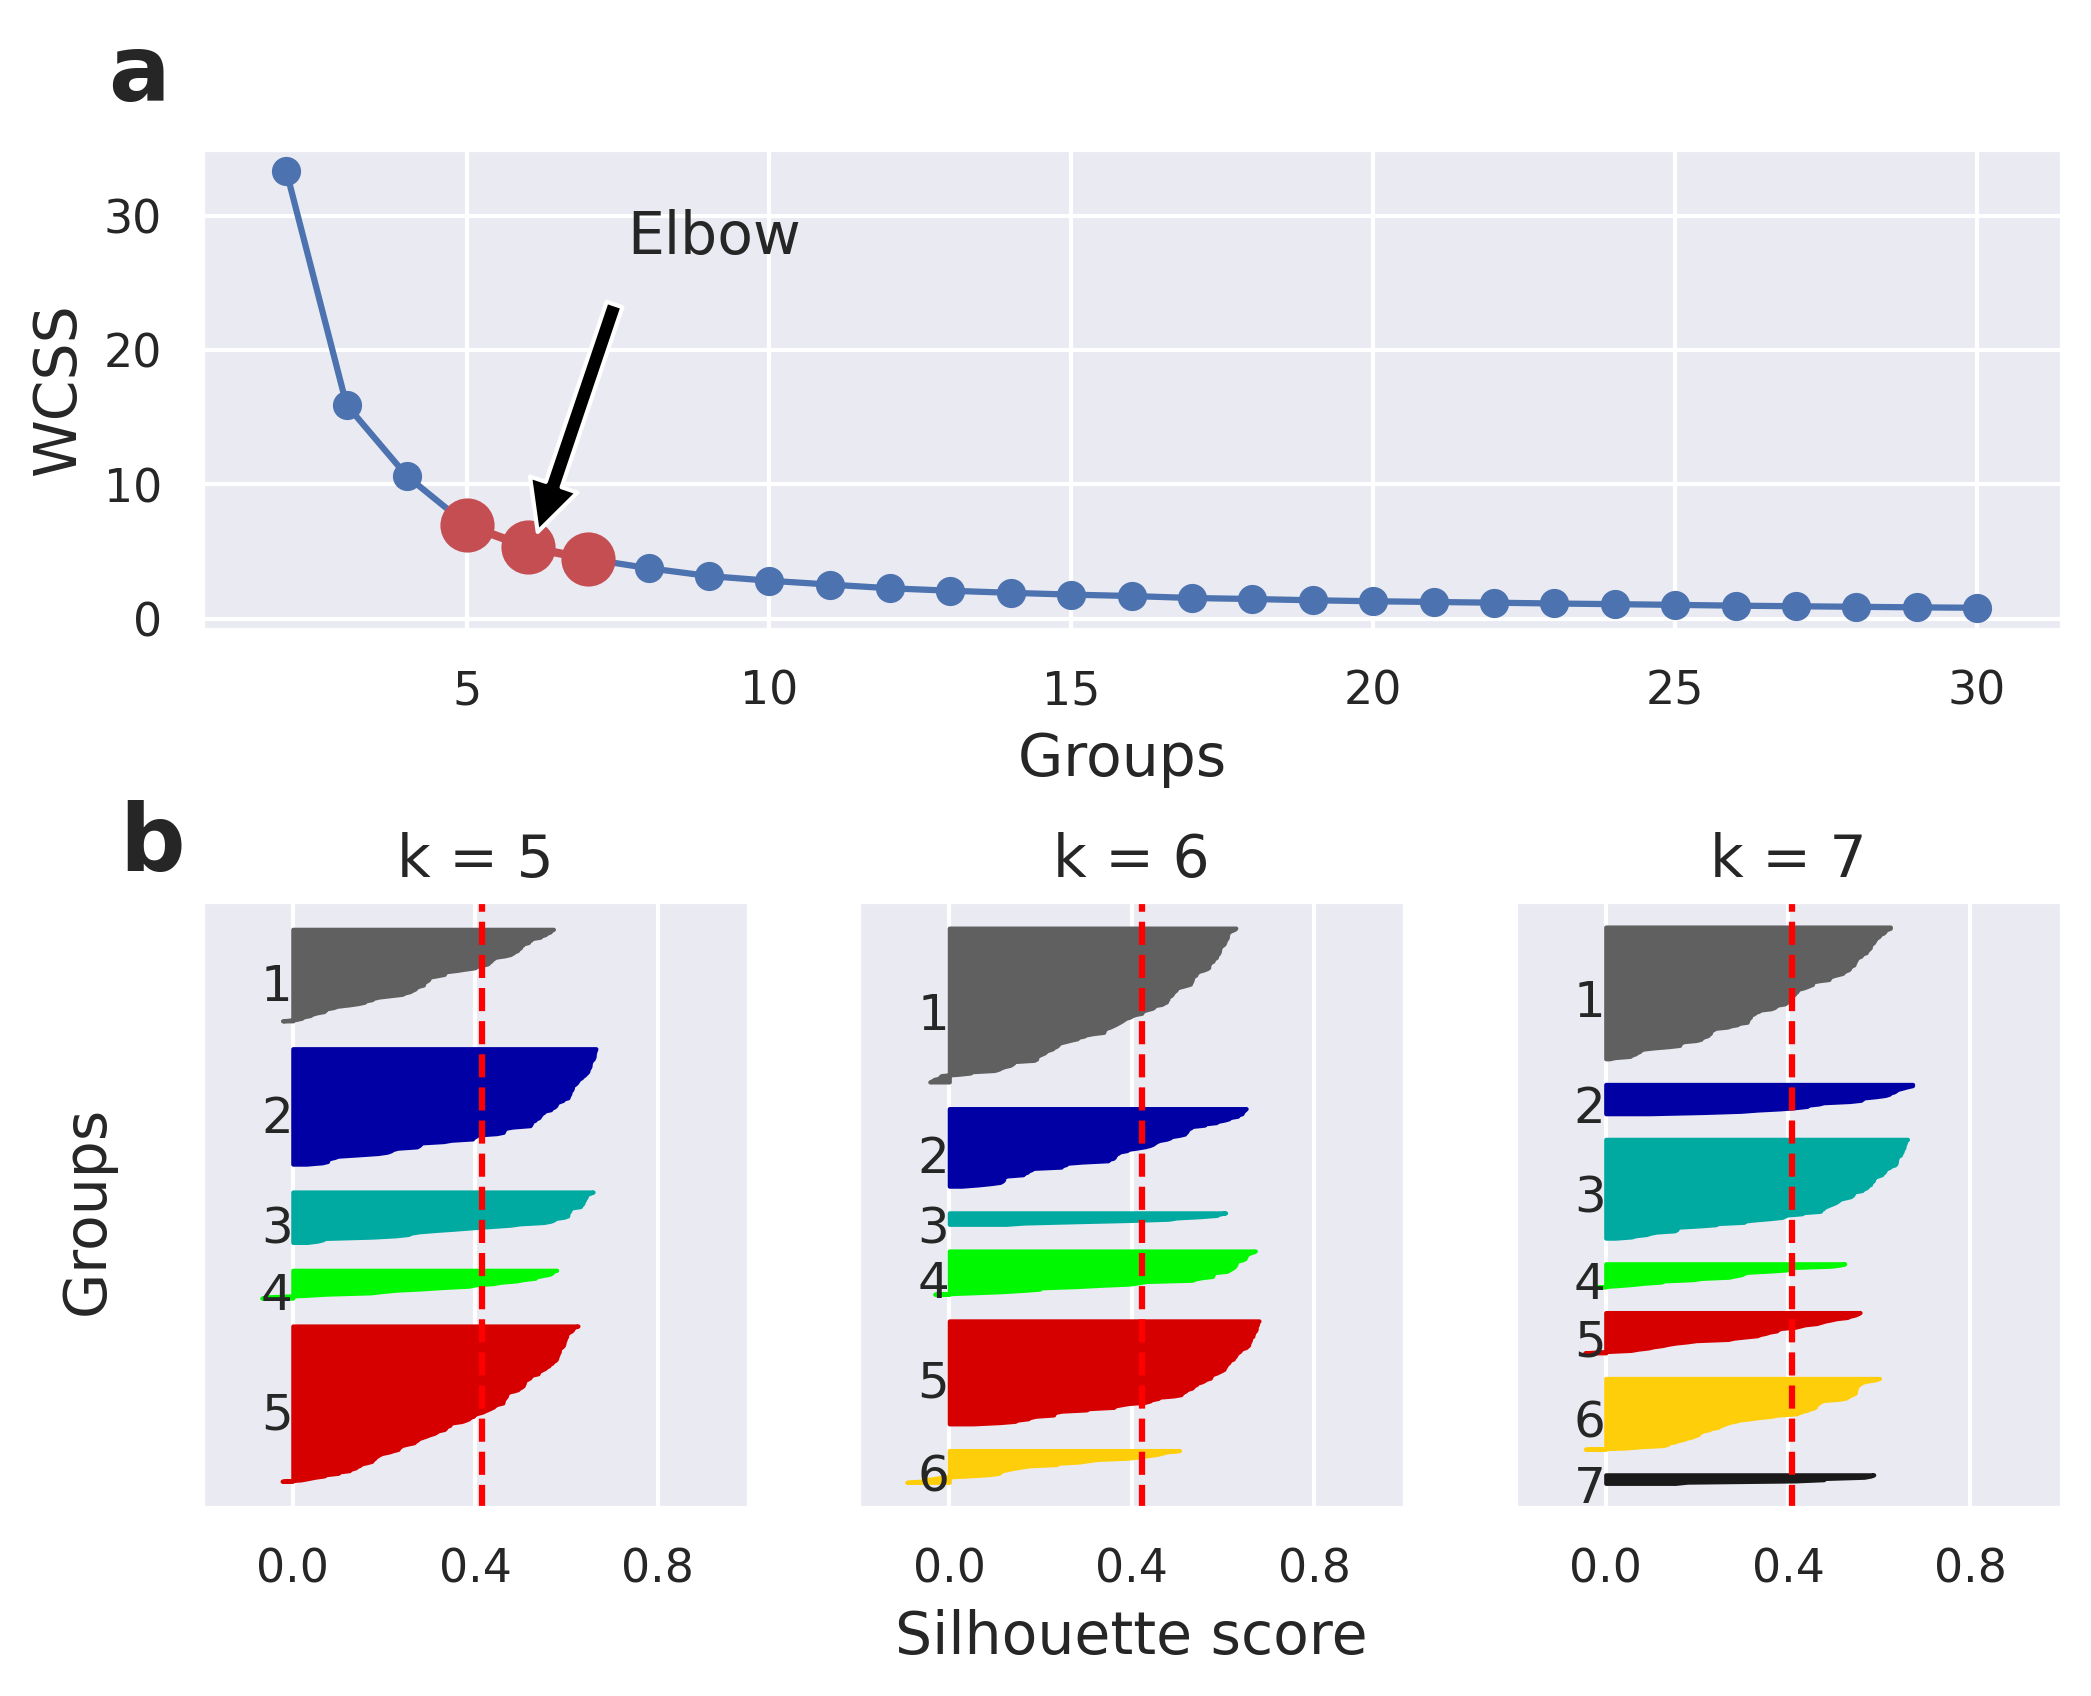

In [11]:
fontsize = 14

lim = 30
sns.set_theme()

fig = plt.figure(figsize = (8, 6), dpi = 300)
gs = gridspec.GridSpec(11, 3)

# elbow graph 
wcss_plot(data_proces[features],lim)

menork = k_opt-1 
maiork = k_opt+1
range_n = range(menork,maiork+1)

# Silhouette graphic
silhouette_plot(data_proces[features])

plt.savefig("/content/matopiba_emissions/output/figure1.pdf", format="pdf", dpi=1000)
plt.show()

In [12]:
#save the data with groups
data.to_csv('/content/matopiba_emissions/data/matopiba_groups.csv', index=False)

In [13]:
#save the centers of clusters
np.save('/content/matopiba_emissions/data/clusters_centers.npy',model_top.cluster_centers_)